In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os

# Configure visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Define paths
DATA_PATH = '../data/telco_customer_churn.csv'
MODELS_DIR = '../models'

# Ensure models directory exists
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
    print(f"Created directory: {MODELS_DIR}")

SCALER_PATH = os.path.join(MODELS_DIR, 'scaler.pkl')
ENCODER_COLUMNS_PATH = os.path.join(MODELS_DIR, 'encoder_columns.json')

In [2]:
# Cell 2: Load Data
try:
    df = pd.read_csv(DATA_PATH)
    print("Data loaded successfully.")
    print("Shape of data:", df.shape)
except FileNotFoundError:
    print(f"Error: The data file was not found at {DATA_PATH}")
    print("Please download 'Telco Customer Churn' from Kaggle and place it in the 'data' directory.")
    df = None # Set df to None if file not found to prevent further errors

if df is not None:
    display(df.head())

Data loaded successfully.
Shape of data: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Cell 3: Initial Data Exploration
if df is not None:
    print("\n--- Data Info ---")
    df.info()

    print("\n--- Descriptive Statistics (Numerical) ---")
    display(df.describe())

    print("\n--- Descriptive Statistics (Categorical) ---")
    display(df.describe(include='object'))

    print("\n--- Missing Values ---")
    print(df.isnull().sum())


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000



--- Descriptive Statistics (Categorical) ---


,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,3186-AJIEK,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174



--- Missing Values ---
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [4]:
# Cell 4: Data Cleaning and Preprocessing
if df is not None:
    # Drop customerID as it's an identifier
    df_processed = df.drop('customerID', axis=1)

    # Convert 'TotalCharges' to numeric.
    # It might contain spaces for new customers (tenure=0), which become NaN.
    df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')

    # For customers with 0 tenure, TotalCharges should be 0.
    # This also handles cases where TotalCharges might be NaN due to 0 tenure.
    df_processed.loc[df_processed['tenure'] == 0, 'TotalCharges'] = 0
    
    # Impute any remaining NaNs in TotalCharges (e.g., if there were other reasons for NaNs)
    # Using median imputation for robustness
    df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median(), inplace=True)
    print(f"\nMissing values in TotalCharges after imputation: {df_processed['TotalCharges'].isnull().sum()}")

    # Convert target variable 'Churn' to numeric (0 or 1)
    df_processed['Churn'] = df_processed['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
    print("\n--- Churn Value Counts (after conversion) ---")
    print(df_processed['Churn'].value_counts())


Missing values in TotalCharges after imputation: 0

--- Churn Value Counts (after conversion) ---
Churn
0    5174
1    1869
Name: count, dtype: int64


C:\Users\prath\AppData\Local\Temp\ipykernel_2276\2232033244.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median(), inplace=True)


C:\Users\prath\AppData\Local\Temp\ipykernel_2276\1958695073.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df_processed, palette='viridis')


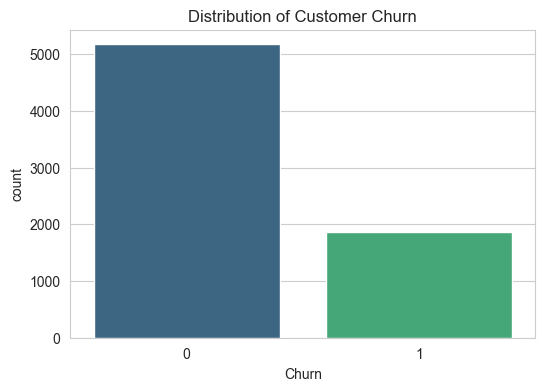

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [5]:
# Cell 5: EDA - Target Variable Distribution
if df is not None:
    plt.figure(figsize=(6,4))
    sns.countplot(x='Churn', data=df_processed, palette='viridis')
    plt.title('Distribution of Customer Churn')
    plt.show()
    print(df_processed['Churn'].value_counts(normalize=True))

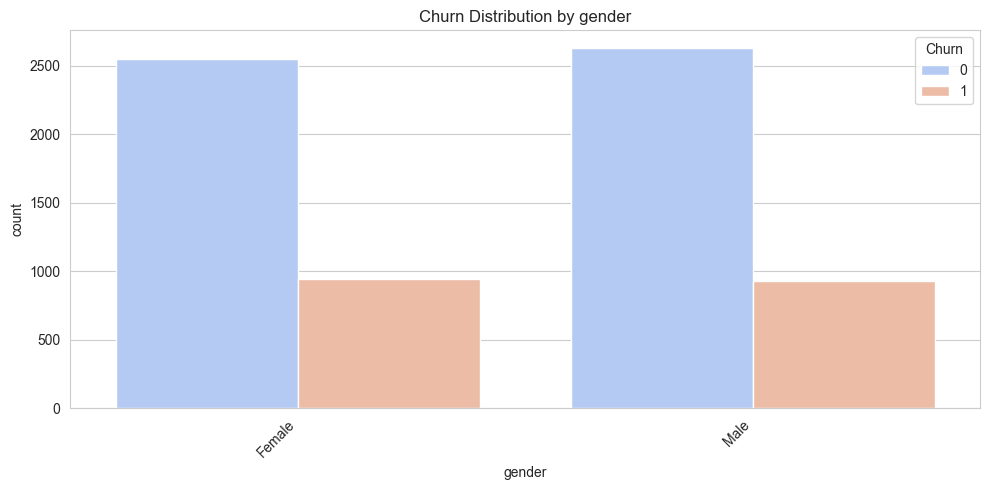

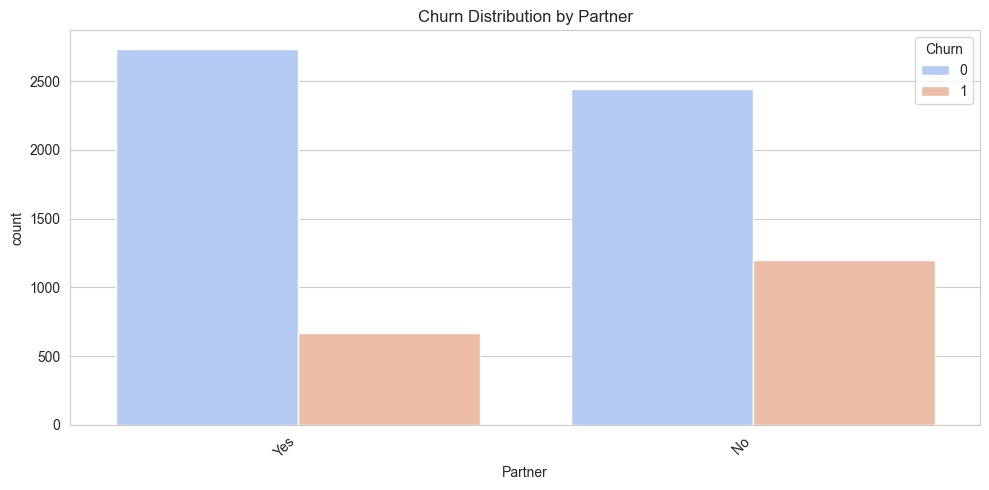

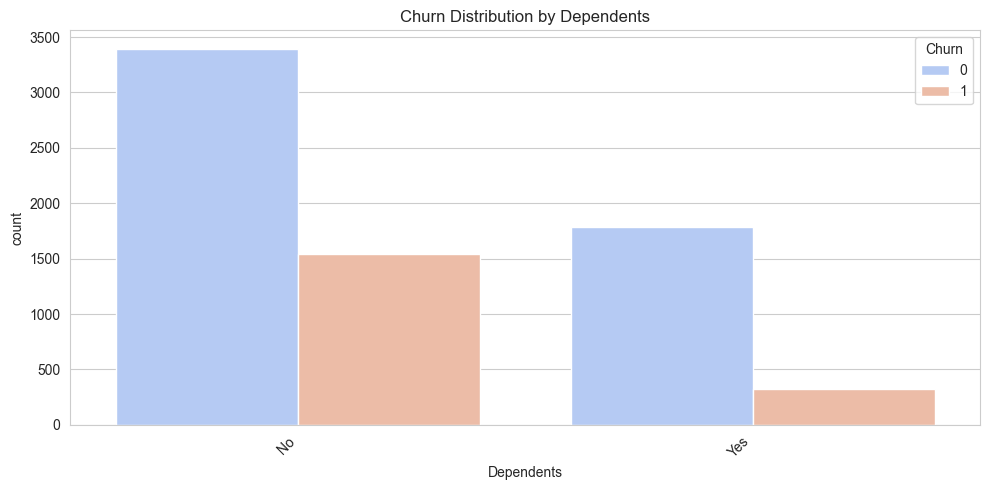

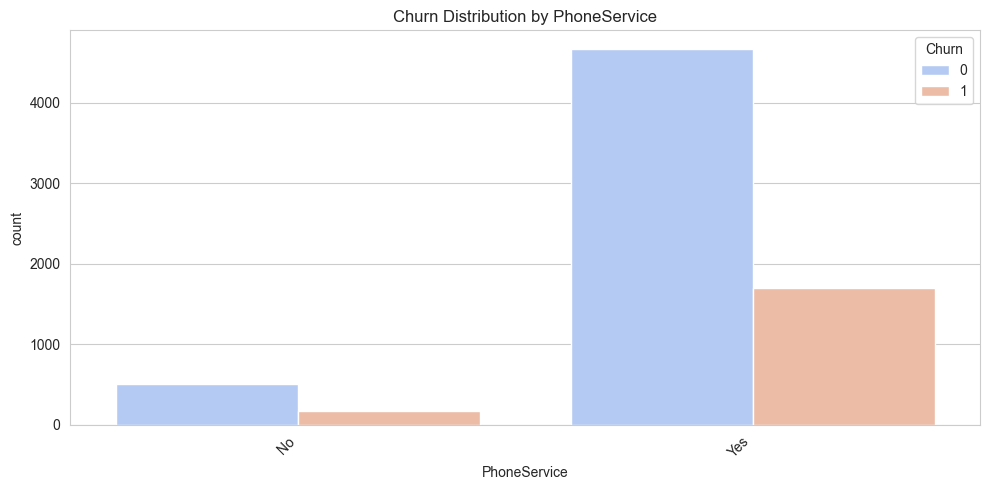

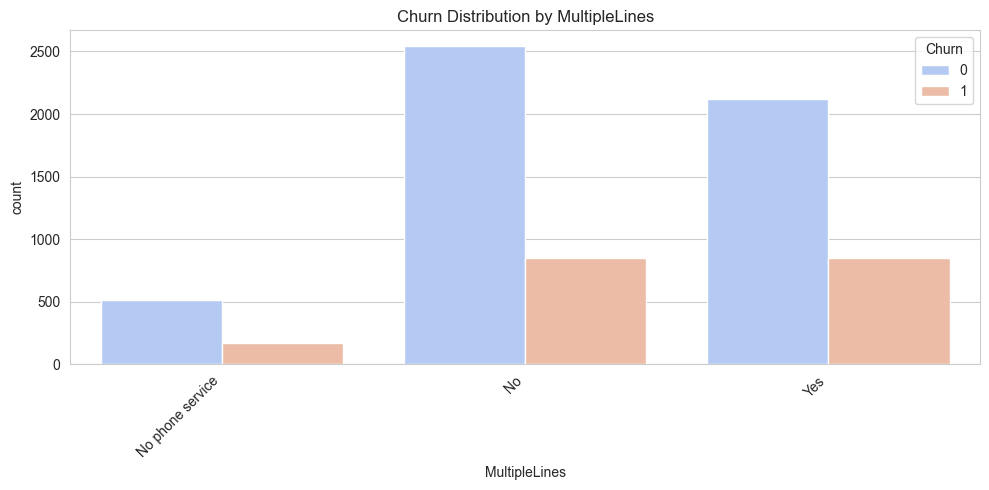

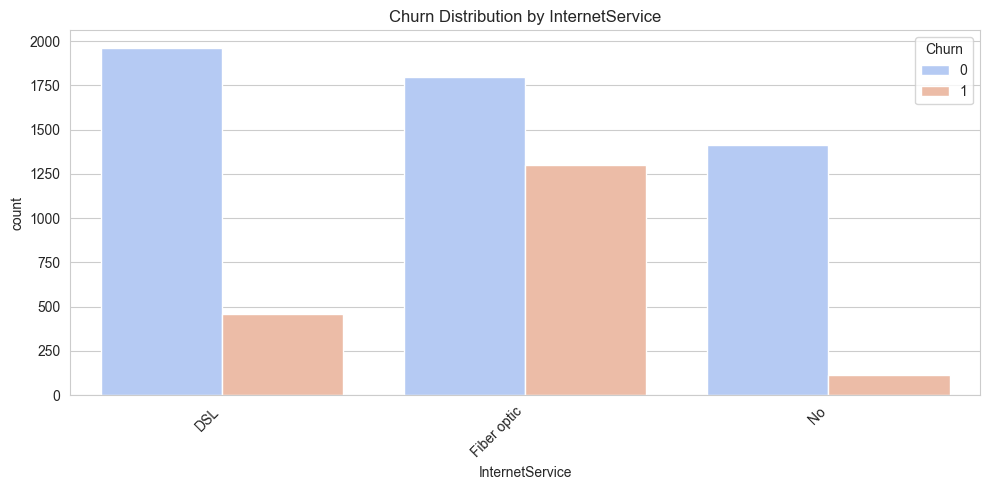

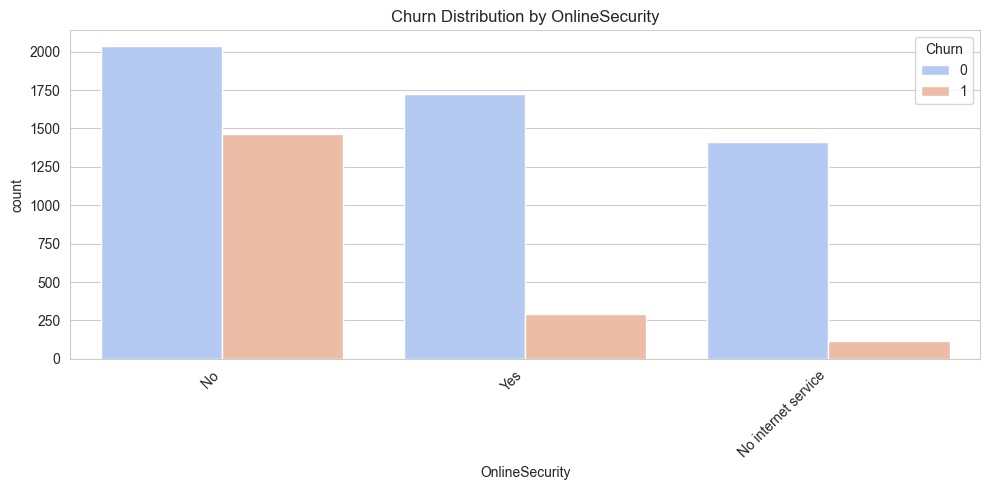

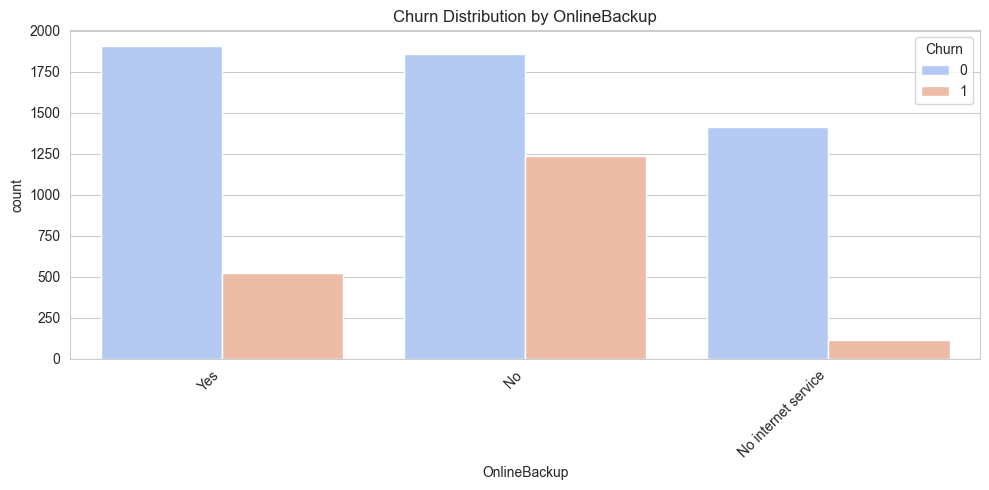

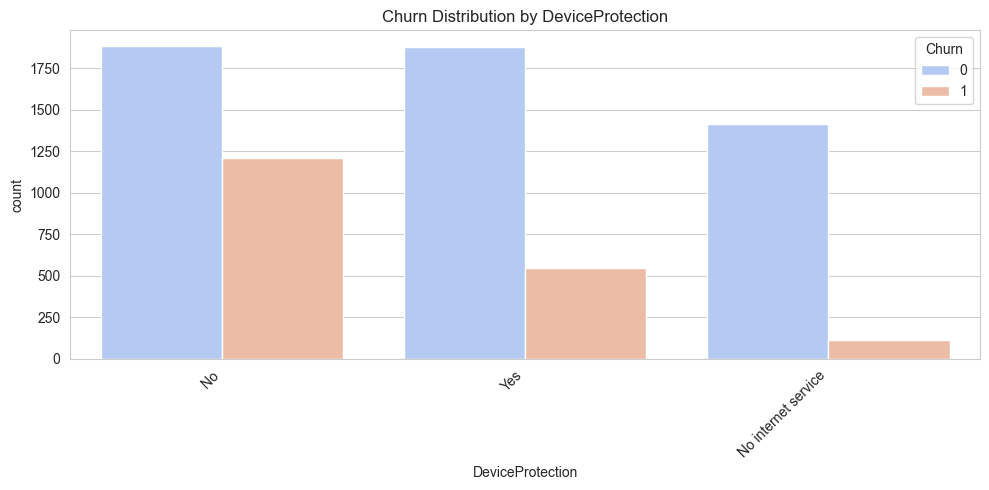

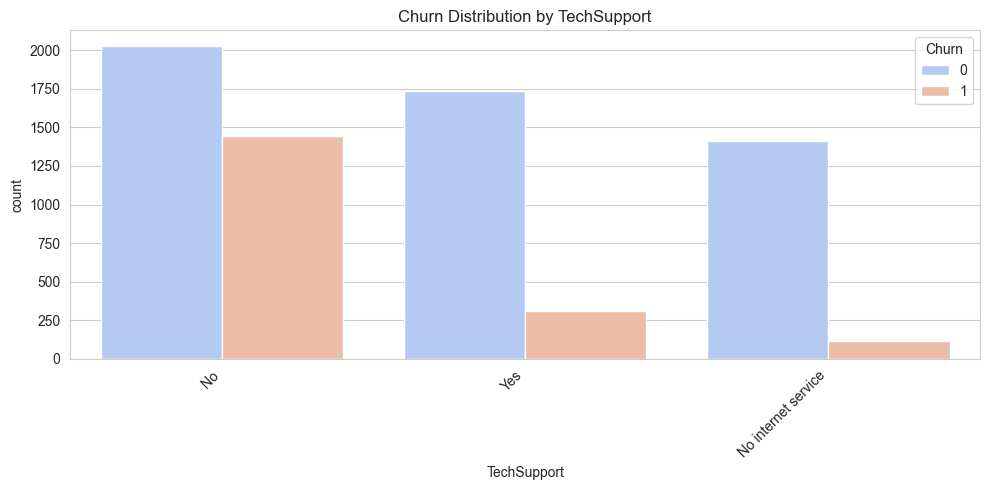

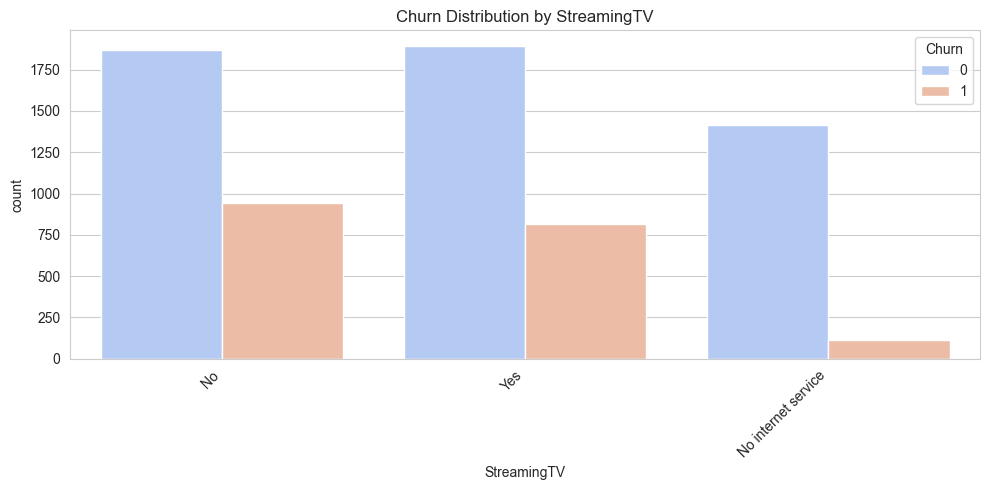

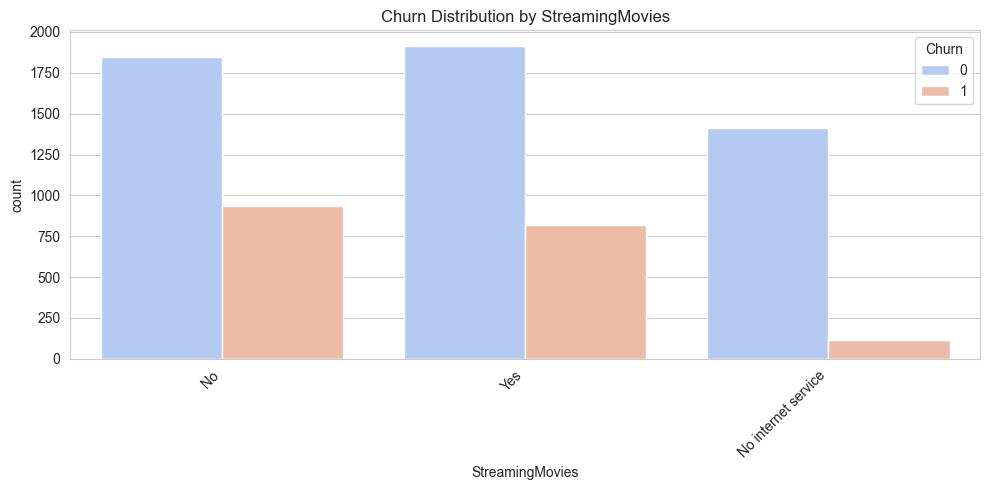

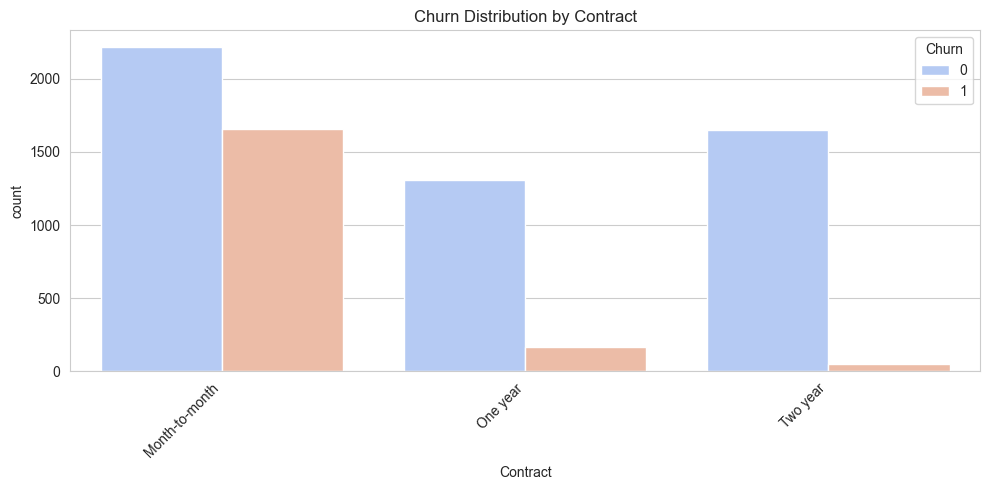

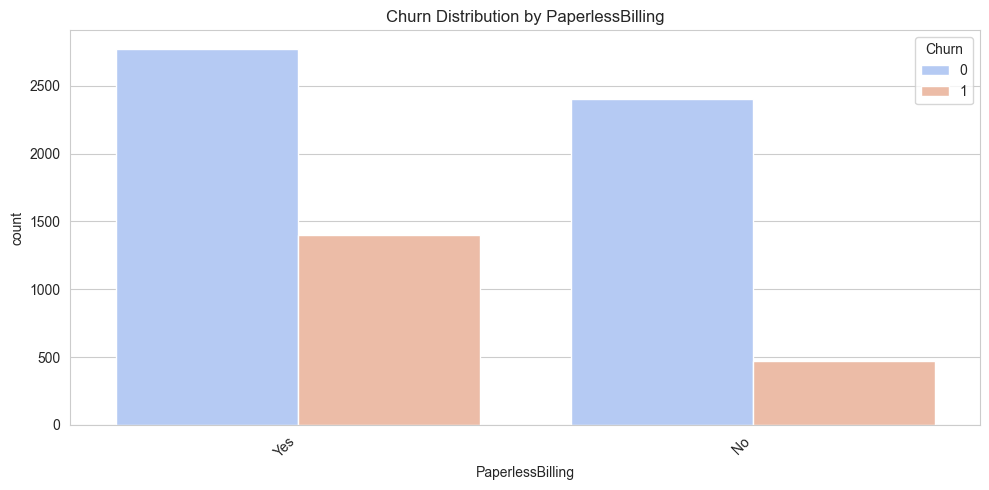

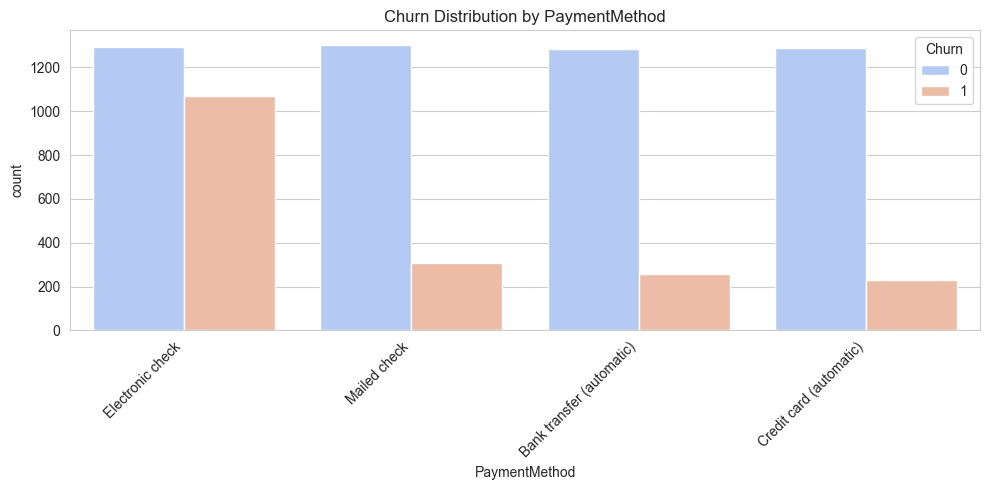

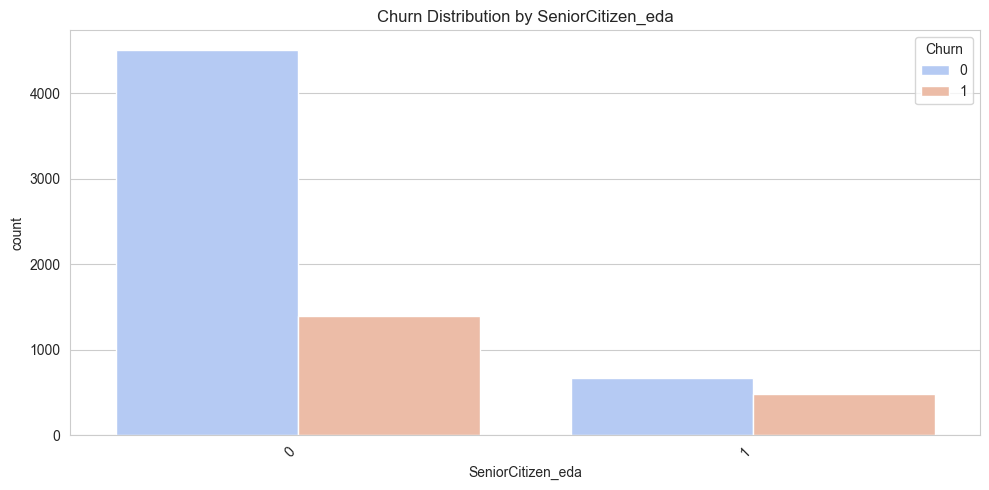

In [6]:
# Cell 6: EDA - Categorical Features vs. Churn
if df is not None:
    categorical_features_for_eda = df_processed.select_dtypes(include='object').columns
    
    # Exclude 'SeniorCitizen' if it's already 0/1, or ensure it's string for consistent EDA plotting
    if 'SeniorCitizen' in df_processed.columns and df_processed['SeniorCitizen'].dtype != 'object':
        df_processed['SeniorCitizen_eda'] = df_processed['SeniorCitizen'].astype(str) # temp for EDA
        if 'SeniorCitizen_eda' not in categorical_features_for_eda:
             categorical_features_for_eda = categorical_features_for_eda.append(pd.Index(['SeniorCitizen_eda']))
    
    for col in categorical_features_for_eda:
        if col in df_processed.columns: # Check if column exists (e.g. SeniorCitizen_eda)
            plt.figure(figsize=(10, 5))
            sns.countplot(x=col, hue='Churn', data=df_processed, palette='coolwarm')
            plt.title(f'Churn Distribution by {col}')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    
    # Clean up temp column if created
    if 'SeniorCitizen_eda' in df_processed.columns:
        df_processed = df_processed.drop('SeniorCitizen_eda', axis=1)

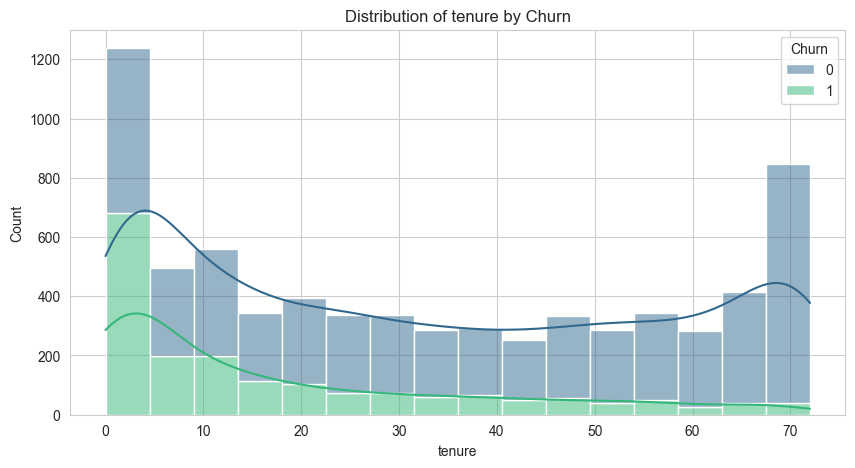

C:\Users\prath\AppData\Local\Temp\ipykernel_2276\2537816609.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df_processed, palette='pastel')


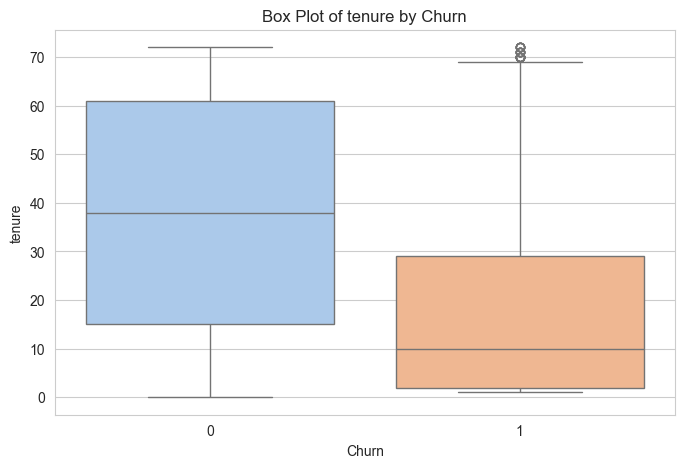

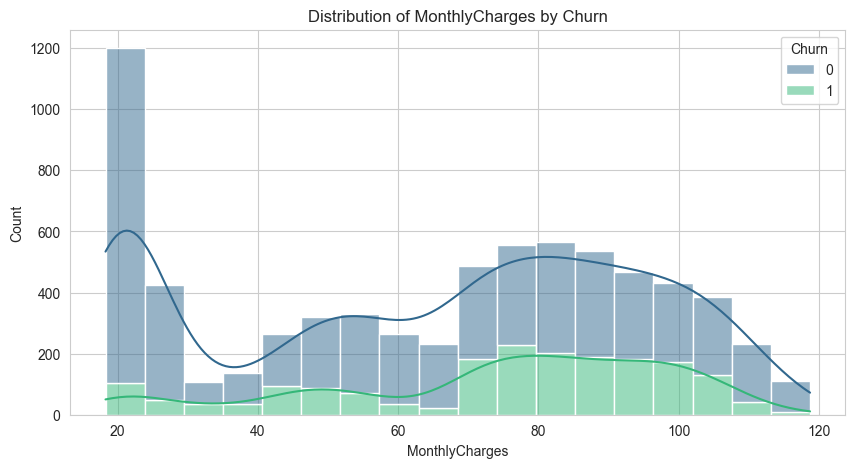

C:\Users\prath\AppData\Local\Temp\ipykernel_2276\2537816609.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df_processed, palette='pastel')


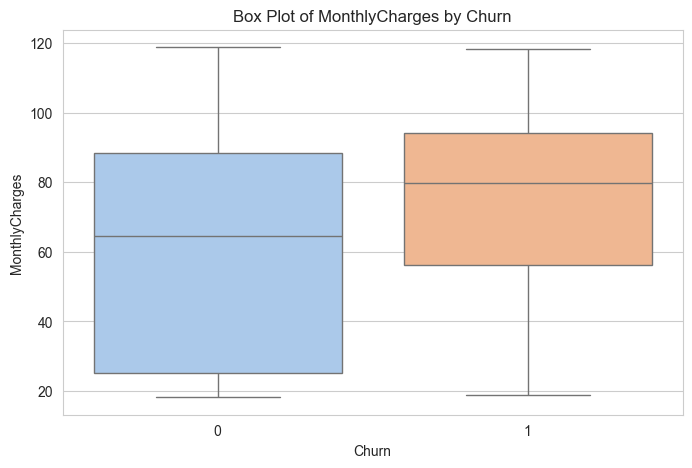

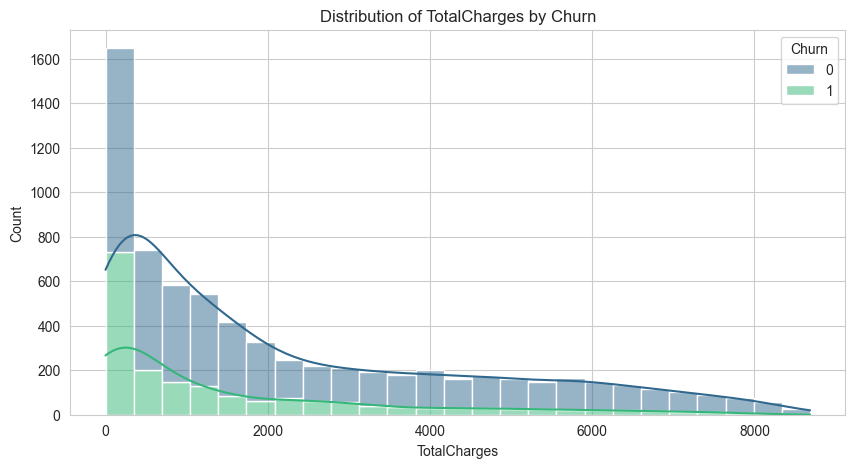

C:\Users\prath\AppData\Local\Temp\ipykernel_2276\2537816609.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df_processed, palette='pastel')


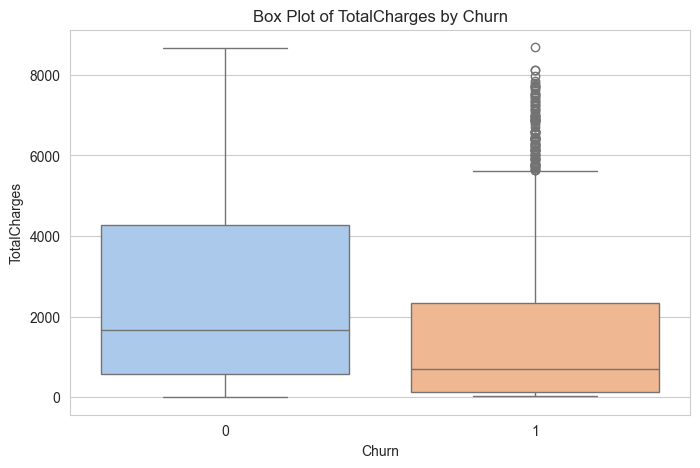

In [7]:
# Cell 7: EDA - Numerical Features vs. Churn
if df is not None:
    numerical_features_for_eda = ['tenure', 'MonthlyCharges', 'TotalCharges']
    for col in numerical_features_for_eda:
        plt.figure(figsize=(10, 5))
        sns.histplot(data=df_processed, x=col, hue='Churn', kde=True, palette='viridis', multiple="stack")
        plt.title(f'Distribution of {col} by Churn')
        plt.show()

        plt.figure(figsize=(8, 5))
        sns.boxplot(x='Churn', y=col, data=df_processed, palette='pastel')
        plt.title(f'Box Plot of {col} by Churn')
        plt.show()

In [8]:
# Cell 8: Feature Engineering - One-Hot Encoding and Scaling Prep
if df is not None:
    # Separate features (X) and target (y)
    X = df_processed.drop('Churn', axis=1)
    y = df_processed['Churn']

    # Identify categorical and numerical columns for transformation
    # SeniorCitizen is numerical (0/1) but for one-hot encoding, it's better to treat it as object/category
    # This ensures consistency if its values were different (e.g. 'Yes'/'No')
    if 'SeniorCitizen' in X.columns:
        X['SeniorCitizen'] = X['SeniorCitizen'].astype(str)

    categorical_cols = X.select_dtypes(include='object').columns.tolist()
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    print("\nCategorical columns for OHE:", categorical_cols)
    print("Numerical columns for Scaling:", numerical_cols)

    # One-Hot Encode categorical features
    # drop_first=True to avoid multicollinearity, though some models handle it.
    # For consistency with app.py if it creates missing columns, it might be simpler not to drop_first
    # However, for model training, drop_first is generally good practice.
    # Let's use drop_first=True for the notebook's model training phase.
    # The app.py's column alignment logic will handle this.
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True) 
    
    print("\nShape of X after One-Hot Encoding:", X_encoded.shape)
    display(X_encoded.head())

    # Save the column names after one-hot encoding (these are what the model will expect)
    # These are the columns of X_encoded
    encoder_cols_list = X_encoded.columns.tolist()
    with open(ENCODER_COLUMNS_PATH, 'w') as f:
        json.dump(encoder_cols_list, f)
    print(f"\nSaved encoded column names to {ENCODER_COLUMNS_PATH}")
    print(f"Number of encoded columns: {len(encoder_cols_list)}")


Categorical columns for OHE: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns for Scaling: ['tenure', 'MonthlyCharges', 'TotalCharges']

Shape of X after One-Hot Encoding: (7043, 30)


,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,False,False,True,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
1,34,56.95,1889.50,True,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,True
2,2,53.85,108.15,True,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
3,45,42.30,1840.75,True,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
4,2,70.70,151.65,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False



Saved encoded column names to ../models\encoder_columns.json
Number of encoded columns: 30


In [9]:
# Cell 9: Train-Test Split
if df is not None:
    from sklearn.model_selection import train_test_split

    # Using X_encoded from the previous cell
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

X_train shape: (5634, 30)
X_test shape: (1409, 30)
y_train shape: (5634,)
y_test shape: (1409,)


In [10]:
# Cell 10: Feature Scaling (Numerical Features)
if df is not None:
    from sklearn.preprocessing import StandardScaler

    # Identify numerical columns in the one-hot encoded X_train dataframe
    # These are the original numerical columns that were not one-hot encoded
    # If a numerical col got OHE (e.g. if SeniorCitizen was int but treated as cat), it won't be in this list.
    # The numerical_cols list defined earlier should be used here on X_train.
    
    # Re-check numerical_cols based on X_train columns to ensure they exist
    # (they should, as they were not part of categorical_cols for OHE)
    num_cols_to_scale = [col for col in numerical_cols if col in X_train.columns]
    print("\nNumerical columns to be scaled in X_train/X_test:", num_cols_to_scale)

    scaler = StandardScaler()

    # Fit scaler on X_train and transform X_train
    X_train[num_cols_to_scale] = scaler.fit_transform(X_train[num_cols_to_scale])

    # Transform X_test using the same fitted scaler
    X_test[num_cols_to_scale] = scaler.transform(X_test[num_cols_to_scale])

    print("\n--- X_train head after scaling ---")
    display(X_train[num_cols_to_scale].head())

    # Save the scaler
    joblib.dump(scaler, SCALER_PATH)
    print(f"\nScaler saved to {SCALER_PATH}")

    # Save preprocessed data (optional, but good for reproducibility in the next notebook)
    # Ensure indices are aligned before saving if you plan to merge X and y later
    X_train.to_csv(os.path.join(MODELS_DIR, 'X_train_processed.csv'), index=False)
    X_test.to_csv(os.path.join(MODELS_DIR, 'X_test_processed.csv'), index=False)
    y_train.to_csv(os.path.join(MODELS_DIR, 'y_train.csv'), index=False, header=['Churn'])
    y_test.to_csv(os.path.join(MODELS_DIR, 'y_test.csv'), index=False, header=['Churn'])
    print("\nProcessed train/test splits saved to models directory for Notebook 02.")
else:
    print("Skipping cells due to data loading failure.")


Numerical columns to be scaled in X_train/X_test: ['tenure', 'MonthlyCharges', 'TotalCharges']

--- X_train head after scaling ---


,tenure,MonthlyCharges,TotalCharges
3738,0.102371,-0.521976,-0.262257
3151,-0.711743,0.337478,-0.503635
4860,-0.793155,-0.809013,-0.749883
3867,-0.263980,0.284384,-0.172722
3810,-1.281624,-0.676279,-0.989374



Scaler saved to ../models\scaler.pkl

Processed train/test splits saved to models directory for Notebook 02.
